# Libraries

In [1]:
import librosa
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import  KerasClassifier
from scipy.stats import randint, uniform
from sklearn.utils import resample
import seaborn as sns


# Load audio and labels

In [2]:
#Load the audio file
audio_path = "clips_lakers.wav"
audio, sr = librosa.load(audio_path, sr=None)

In [3]:
#Load labels from CSV file
labels_path = "annotation.csv"
labels_df = pd.read_csv(labels_path)
labels_df.drop(['VALUE'], axis=1)

,TIME,DURATION,LABEL
0,25.353288,2.641270,cheering
1,68.057687,3.125986,boos
2,72.759728,0.017415,cheering
3,83.043265,3.700680,boos
4,126.656145,1.367075,cheering
...,...,...,...
307,5671.632109,0.114649,whistle
308,5684.033016,2.016508,air_horn
309,5708.364626,0.274286,whistle
310,5717.298503,1.648617,air_horn


# Feature extraction and labelling

In [4]:
n_fft = 2048
hop_length = 512

In [5]:
#Mel Frequency Cepstral Coefficients



mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

In [6]:
#Mel Spectrogram

mel_spectrograms = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)  

In [7]:
#Spectral Centroid

centroids = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)

In [8]:
#Zero Crossing Rate

zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length)

In [9]:
#Chromagram

chroma = librosa.feature.chroma_stft(y=audio, hop_length=hop_length)

In [10]:
#spectral flatness

flatness = librosa.feature.spectral_flatness(y=audio, hop_length=hop_length)

In [11]:
#Spectral rolloff

rolloff = librosa.feature.spectral_rolloff(y=audio, hop_length=hop_length)

In [8]:
#Root-mean-square(RMS) value

rms = librosa.feature.rms(y=audio, hop_length=hop_length)

In [9]:
#spectral contrast

contrast = librosa.feature.spectral_contrast(y=audio, n_fft=n_fft, hop_length=hop_length)

In [10]:
#spectral bandwidth

bandwidth = librosa.feature.spectral_bandwidth(y=audio, n_fft=n_fft, hop_length=hop_length)

In [ ]:
#Concatenate multiple audio features
concatenated_features = []

for i in range(mfccs.shape[1]):
  frame_features = np.concatenate((mfccs[:, i], mel_spectrograms[:, i], zcr[:, i], chroma[:, i], flatness[:, i], rolloff[:, i], rms[:, i], contrast[:, i], bandwidth[:, i]))
  concatenated_features.append(frame_features)

In [ ]:
#Stack concatenated features to create a single numpy array of shape:
#(num_of_samples, num_of_features)

concatenated_features = np.stack(concatenated_features)

In [5]:
concatenated_features = np.load("audio_features.npy")

In [6]:
#Label concatenated_features frames based on the corresponding CSV labels

# concatenated_features_labels = np.zeros(concatenated_features.shape[0])
# labeled_windows = []

# for i, row in labels_df.iterrows():
#   start_time = row["TIME"]
#   end_time = start_time + row["DURATION"]
#   label = row["LABEL"]

#   # Convert start and end times from seconds to frame indices.
#   start_frame = int(start_time * sr/hop_length)
#   end_frame = int(end_time * sr/hop_length)

#   if row['LABEL'] == 'cheering':
#     concatenated_features_labels[start_frame:end_frame] = 1

#   elif row['LABEL'] == 'whistle':
#     concatenated_features_labels[start_frame:end_frame] = 2


#   elif row['LABEL'] == 'air_horn':
#     concatenated_features_labels[start_frame:end_frame] = 3

In [ ]:
#create separate windows of 20 consecutive frames(window duration : 1s.)

#window shape: (#frames/window_size, #features*window_size)

windows = []
window_size = 10 #number of frames per window

for i in range(0, len(concatenated_features), window_size):
    window = np.concatenate(concatenated_features[i : i+window_size], axis=0)
    print(window.shape)
    if len(window) == window_size*len(concatenated_features[0]): # Check if the window has the desired number of frames
        windows.append(window)

windows = np.array(windows)


In [61]:
#Label windows using majority voting

num_frames = concatenated_features.shape[0]
num_windows = windows.shape[0]
windows_labels = []

#Iterate over each window

for i in range(num_windows):
    window_start = i * window_size
    window_end = (i + 1) * window_size

    #Count occurrences of each class in the window

    class_counts = {'0': 0, '1': 0, '2': 0, '3': 0}

    for frame_index in range(window_start, window_end):
        frame_label = str(int(concatenated_features_labels[frame_index]))
        class_counts[frame_label] += 1

    # Determine the majority class for the window
    majority_class = max(class_counts, key=class_counts.get)

    # Assign the majority class label to the entire window
    window_label = int(majority_class)
    #add label to labels list
    windows_labels.append(window_label)

#Convert list to numpy array  
windows_labels = np.array(windows_labels)


# Preprocessing

In [62]:
#Scaling for WINDOWS
scaler = StandardScaler()
window_features_std = scaler.fit_transform(windows)

In [29]:
#InformationGain for optimal feature selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def select_optimal_features(features, labels, k):
    # Create an instance of the SelectKBest class with mutual information as the scoring function
    selector = SelectKBest(score_func=mutual_info_classif, k=k)

    # Fit the selector to the features and labels
    selector.fit(features, labels)

    # Get the scores and indices of the top k features
    scores = selector.scores_
    feature_indices = np.argsort(scores)[::-1][:k]

    # Select the top k features from the original feature array
    selected_features = features[:, feature_indices]

    return selected_features

# Assuming you have a NumPy array of audio features called "audio_features"
# and a NumPy array of corresponding labels called "labels"

# Set the number of optimal features to select
k = 20

# Call the function to select the optimal features
selected_features = select_optimal_features(concatenated_features, concatenated_features_labels, k)


In [10]:
#Principal Component Analysis(PCA) for dimensionality reduction

pca = PCA()
pca.fit(features_std)
evr = pca.explained_variance_ratio_

for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps) #Number of components necessary to preserve around 80% of variance
pca = PCA(n_components=n_comps)
pca.fit(features_std)
scores_pca = pca.transform(features_std)

Number of components: 59


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scores_pca, concatenated_features_labels, test_size=0.2)

#Downsample X_train to have equal number of each event(to avoid overfitting)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

X_train_0_downsampled = resample(X_train_0, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_1_downsampled = resample(X_train_1, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_3_downsampled = resample(X_train_3, replace=False, n_samples=X_train_2.shape[0], random_state=123)


X_train_downsampled = np.vstack((X_train_0_downsampled, X_train_1_downsampled, X_train_2, X_train_3_downsampled))
y_train_downsampled = np.hstack((np.zeros(X_train_0_downsampled.shape[0]), np.ones(X_train_1_downsampled.shape[0]), np.full(X_train_2.shape[0], 2), np.full(X_train_3_downsampled.shape[0], 3)))


In [63]:
# Split the data into training and testing sets for WINDOWS
X_train, X_test, y_train, y_test = train_test_split(window_features_std, windows_labels, test_size=0.2)

#Downsample X_train to have equal number of each event(to avoid overfitting)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

X_train_0_downsampled = resample(X_train_0, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_1_downsampled = resample(X_train_1, replace=False, n_samples=X_train_2.shape[0], random_state=123)
X_train_3_downsampled = resample(X_train_3, replace=False, n_samples=X_train_2.shape[0], random_state=123)


X_train_downsampled = np.vstack((X_train_0_downsampled, X_train_1_downsampled, X_train_2, X_train_3_downsampled))
y_train_downsampled = np.hstack((np.zeros(X_train_0_downsampled.shape[0]), np.ones(X_train_1_downsampled.shape[0]), np.full(X_train_2.shape[0], 2), np.full(X_train_3_downsampled.shape[0], 3)))


# Build ANN for classification


In [64]:
#Define the number of classes
num_classes = 4


# #Define ANN model
def ANN_model(input_shape=windows.shape[1], activation='relu', optimizer='adam'):

    model = Sequential()
    model.add(Dense(100, input_shape = (input_shape,), activation=activation)) #fix input_shape depending on input
    model.add(Dropout(0.5))
    ###second layer
    model.add(Dense(200, activation=activation))
    model.add(Dropout(0.5))
    ###third layer
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.5))
    ###final layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax')) 

    model.summary()

    # Compile the model
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [65]:
#Train model on windows
model = ANN_model()
model.fit(X_train_downsampled, y_train_downsampled, epochs=100, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               165100    
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 200)               20200     
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 4)                

C:\Users\MANOS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 1s 5ms/step - loss: 2.1852 - accuracy: 0.3252
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 1.6087 - accuracy: 0.4029
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 1.1195 - accuracy: 0.5995
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 1.1190 - accuracy: 0.6141
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.8727 - accuracy: 0.6917
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7038 - accuracy: 0.7233
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.6055 - accuracy: 0.7621
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5817 - accuracy: 0.8204
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5340 - accuracy: 0.8107
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4761 - accuracy: 0.8252
Epoch 11/100
13/13 [=

In [67]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

315/315 [==============================] - 1s 3ms/step - loss: 1.8612 - accuracy: 0.8048
Test loss: 1.8612295389175415
Test accuracy: 0.804751992225647


315/315 [==============================] - 1s 3ms/step
Precision score: 0.8047519634158465
 Recall score: [0.79978518 0.85735513 1.         0.92156863]


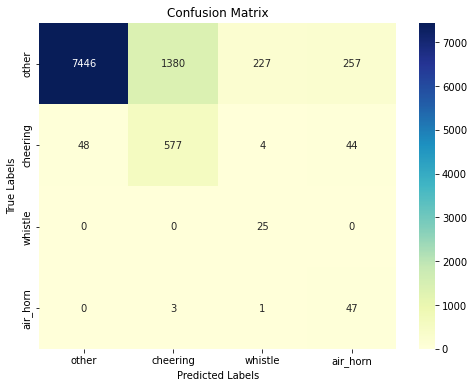

In [68]:
#Print confusion matrix to see values distribution on each class

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) #convert probability for each class into class prediction
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average=None)
print("Precision score: " +str(precision)+ "\n Recall score: "+str(recall))
confusion_mat = confusion_matrix(y_test, y_pred)

class_labels = ['other', 'cheering', 'whistle', 'air_horn']
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ANN performance for concatenated_features without PCA

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_std, concatenated_features_labels, test_size=0.2)

X_train_0_all = X_train[y_train == 0]
X_train_1_all = X_train[y_train == 1]
X_train_2_all = X_train[y_train == 2]
X_train_3_all = X_train[y_train == 3]

X_train_0_downsampled_all = resample(X_train_0_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)
X_train_1_downsampled_all = resample(X_train_1_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)
X_train_3_downsampled_all = resample(X_train_3_all, replace=False, n_samples=X_train_2_all.shape[0], random_state=123)


X_train_downsampled_all = np.vstack((X_train_0_downsampled_all, X_train_1_downsampled_all, X_train_2_all, X_train_3_downsampled_all))
y_train_downsampled_all = np.hstack((np.zeros(X_train_0_downsampled_all.shape[0]), np.ones(X_train_1_downsampled_all.shape[0]), np.full(X_train_2_all.shape[0], 2), np.full(X_train_3_downsampled_all.shape[0], 3)))


In [25]:
model = ANN_model(concatenated_features.shape[1])
model.fit(X_train_downsampled_all, y_train_downsampled_all, epochs=50, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               15700     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

3144/3144 [==============================] - 7s 2ms/step - loss: 0.4638 - accuracy: 0.8827
Test loss: 0.4638045132160187
Test accuracy: 0.8827447891235352


# Fine-tuning via GridSearch

In [69]:
model = KerasClassifier(build_fn=ANN_model)

param_grid = {
    'optimizer' : ['rmsprop', 'SGD', 'adam'],
    'activation' : ['relu', 'sigmoid'],
    # 'batch_size': [32, 64, 128],
    # 'epochs': [50, 75, 100]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='accuracy')
grid_result = grid.fit(X_train_downsampled, y_train_downsampled)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\MANOS\AppData\Local\Temp/ipykernel_1212/285734137.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=ANN_model)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 100)               165100    
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               20200     
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               20100     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 4)                

C:\Users\MANOS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 1s 5ms/step - loss: 2.0859 - accuracy: 0.3859
Best: 0.294946 using {'activation': 'relu', 'optimizer': 'rmsprop'}


# Results(accuracy, loss)

## PCA

  Training - accuracy: 0.94, loss: 0.15
  Testing - accuracy: 0.85, loss: 0.4

## NO PCA
  Training - accuracy:0.95, loss:0.13
  Testing - accuracy: 0.88, loss:0.46